In [1]:
import time, copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter

In [2]:
def gauss(x, b=0, c=1):
    return np.exp(-(x-b)**2/(2*c**2))

def gauss_kx(x, kx, b=0, c=1):
    return gauss(x, b, c) * np.exp(1j * kx * x)

def get_BC_kx(x_0, x_max, x_step, kx, beam_center=0, waist=1):
    BC = [gauss_kx(x, kx, beam_center, waist) for x in np.arange(x_0, x_max, x_step)]
    return np.array(BC)

def smooth(vec, smoothen=10):
    s_vec = np.pad(vec, (smoothen//2, smoothen-smoothen//2), mode='edge')
    return np.cumsum(s_vec[smoothen:] - s_vec[:-smoothen]) / smoothen

In [70]:
def n_vec_sqr(x, x_star=2.5):
    coef = np.power(0.005, 1/4) / x_star
    if np.abs(x) <= x_star:
        val = 1 + (coef * x)**4
    else:
        val = 1.005
    return val**2 - 1

def moving_avg(vec, smooth_size=5):
    cs = np.cumsum(np.insert(vec, 0, 0)) 
    return (cs[smooth_size:] - cs[:-smooth_size]) / smooth_size

def dEdz_vec(E, x, k, n_sqr_minus, ddx):
    V_eff = k * (n_sqr_minus) / 2
    return (((-V_eff * E) - ddx/(2*k)) / 1j)

def RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_sqr, smooth_val):
    # list of zvals
    z_list = np.arange(z_0, z_max, z_step)
    
    # list of xvals
    x_list = np.arange(x_0, x_max, x_step)
        
    # grid of E vals starts as just the boundary conditions
    E_grid = [BC]
    
    # loop over z's
    for i in tqdm(range(int((z_max - z_0) / z_step))):
        # 1st derivative
        der_1 = np.gradient(E_grid[i], x_step, edge_order=1)
        
        # 2nd derivative
        der_vals = np.gradient(der_1, x_step, edge_order=1)
        
        k1_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals)
        k2_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals + 0.5 * k1_vec)
        k3_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals + 0.5 * k2_vec)
        k4_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_sqr, der_vals + k3_vec)
        
        new_slice = E_grid[i] + k1_vec/6 + k2_vec/3 + k3_vec/3 + k4_vec/6

        E_grid.append(new_slice)
        
    # 64 bit floats instead of 128 to help memory usage
    return np.array(E_grid, dtype=np.complex64)

In [71]:
def get_angle(k, kx):
    return np.arcsin(kx / k)

def get_kz(k, angle):
    return np.cos(angle) * k

In [89]:
# physical params
lam = 200 * 10**(-3) # micrometers
# lam = 200 * 10**(-9) # meters
k = 2*np.pi/lam

# beam params (micrometers)
beam_center = -10
waist = 3

# spatial params (micrometers)
x_step = 10**(-1)
x_0 = -15
x_max = 5

z_step = 10**(-2)
z_0 = 0
z_max = 0.5*10**(3)
hlim = z_max / z_step

kxs = np.arange(0, 0.1, 0.02)

angles = get_angle(k, kxs)
kzs = get_kz(k, angles)

x_list = np.arange(x_0, x_max, x_step)
n_list = np.array([n_vec_sqr(x) for x in x_list])

s_val = 25
p_val = 7
ss_val = 5
n_smooth = savgol_filter(n_list, s_val, p_val)
n_ss = uniform_filter1d(n_smooth, ss_val)

Text(0, 0.5, 'max z needed')

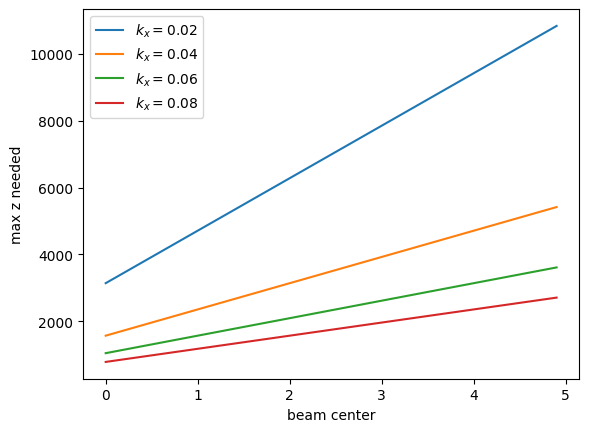

In [128]:
bcs = np.arange(0, 5, 0.1)
idx = 1
for angle in angles:
    crossings = []
    if angle != 0:
        for bc in bcs:
            crossings.append((bc+2)/np.tan(angle))
        plt.plot(bcs, crossings, label="$k_x=$"+str(kxs[idx]))
        idx+=1
plt.legend()
plt.xlabel("beam center")
plt.ylabel("max z needed")

3926.978084571153


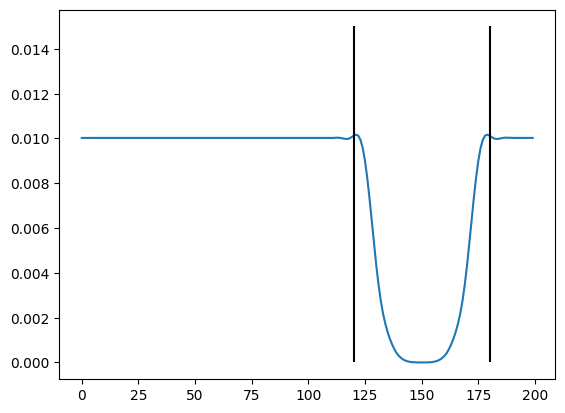

In [110]:
barrier = 120
barrier1 = 180

plt.plot(n_ss)
plt.vlines(barrier, 0, 0.015, color="0")
plt.vlines(barrier1, 0, 0.015, color="0")

idx = 4

print(-beam_center/np.tan(angles[idx]))

In [93]:
idx = 4

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_ss, 10)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9245.32it/s]


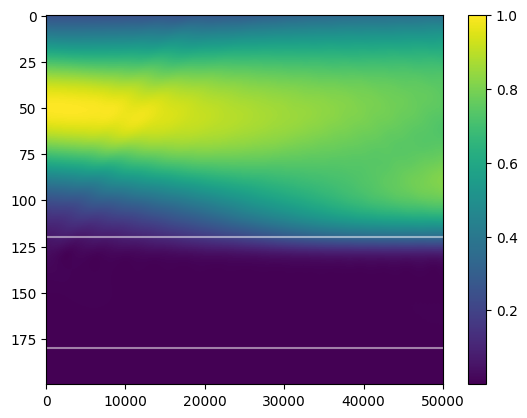

In [94]:
plt.imshow(np.abs(E_grid.T), aspect="auto")

plt.colorbar()

plt.hlines(barrier, 0, hlim, color="white", alpha=0.5)
plt.hlines(barrier1, 0, hlim, color="white", alpha=0.5)

In [9]:
# pwr = []
# z_list = np.arange(0, 50001)
# for z_slice in z_list:
#     pwr.append((np.abs(E_grid[z_slice])**2).sum())
# plt.plot(z_list, pwr)

In [10]:
# kx = 0

# # z_slice = 7*10**3
# barrier = 120
# barrier1 = 180
# hlim = 10**4


# plt.imshow(np.abs(E_grid.T), aspect="auto")

# plt.hlines(barrier, 0, hlim, color="white", alpha=0.5)
# plt.hlines(barrier1, 0, hlim, color="white", alpha=0.5)
# for number in [5,6,7,8,9,10]:
#     z_slice = number * 10**3
#     print(number)
#     plt.vlines(z_slice, 0, 300, color="white", alpha=0.5)

#     a = (np.abs(E_grid[z_slice][:barrier])**2).sum()
#     A = (np.abs(E_grid[z_slice][barrier:])**2).sum()
#     print(a/(a+A))
#     print("")
    
    
    
print("kx=0 -> prop ref=99%")

kx=0 -> prop ref=99%


5
0.0

6
nan

7
nan

8
nan

9
nan

10
nan

kx=0.02 -> prop ref=0.88688135


C:\Users\Owner\AppData\Local\Temp\ipykernel_10748\1663950926.py:8: RuntimeWarning: overflow encountered in absolute
  plt.imshow(np.abs(E_grid.T), aspect="auto")
C:\Users\Owner\AppData\Local\Temp\ipykernel_10748\1663950926.py:18: RuntimeWarning: overflow encountered in square
  b = (np.abs(E_grid[z_slice][barrier:])**2).sum()
C:\Users\Owner\AppData\Local\Temp\ipykernel_10748\1663950926.py:17: RuntimeWarning: overflow encountered in square
  a = (np.abs(E_grid[z_slice][:barrier])**2).sum()
C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Owner\AppData\Local\Temp\ipykernel_10748\1663950926.py:19: RuntimeWarning: invalid value encountered in scalar divide
  print(a/(a+b))


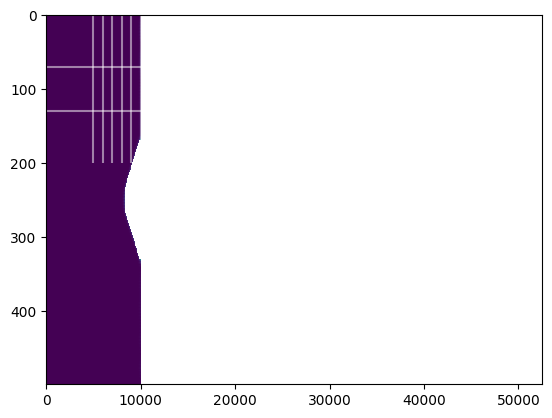

In [11]:
# kx = 0.02

z_slice = 7*10**3
barrier = 70
barrier1 = 130


plt.imshow(np.abs(E_grid.T), aspect="auto")

plt.hlines(barrier, 0, 0.5*10**5, color="white", alpha=0.5)
plt.hlines(barrier1, 0, 0.5*10**5, color="white", alpha=0.5)
for number in [5,6,7,8,9,10]:
    z_slice = number * 10**3
    print(number)
    plt.vlines(z_slice, 0, 200, color="white", alpha=0.5)

    a = (np.abs(E_grid[z_slice][:barrier])**2).sum()
    b = (np.abs(E_grid[z_slice][barrier:])**2).sum()
    print(a/(a+b))
    print("")
    
print("kx=0.02 -> prop ref=0.88688135")

In [12]:
# # kx = 0.04

# barrier = 70
# barrier1 = 130


# plt.imshow(np.abs(E_grid.T), aspect="auto")

# plt.hlines(barrier, 0, 0.5*10**5, color="white")
# plt.hlines(barrier1, 0, 0.5*10**5, color="white")
# for number in [5,6,7,8,9,10]:
#     z_slice = number * 10**3
#     print(number)
#     plt.vlines(z_slice, 0, 200, color="white")

#     a = (np.abs(E_grid[z_slice][:barrier])**2).sum()
#     b = (np.abs(E_grid[z_slice][barrier:])**2).sum()
#     print(a/(a+b))
#     print(b/(a+b))
#     print("")
    
print("kx=0.02 -> prop ref=0.8822878")

kx=0.02 -> prop ref=0.8822878


C:\Users\Owner\AppData\Local\Temp\ipykernel_10748\442151880.py:5: RuntimeWarning: overflow encountered in absolute
  plt.imshow(np.abs(E_grid.T), aspect="auto")


IndexError: index 17000 is out of bounds for axis 0 with size 10001

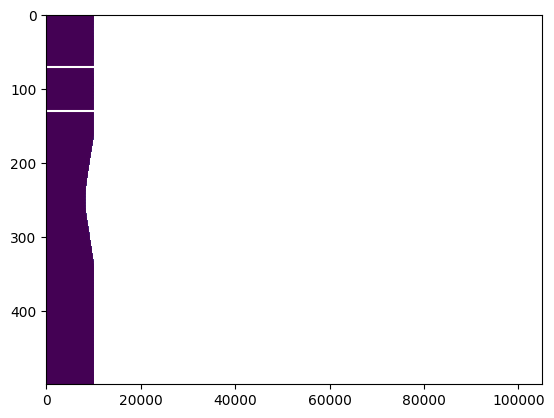

In [13]:
# angle = 1/20

z_slice = 17*10**3

plt.imshow(np.abs(E_grid.T), aspect="auto")

plt.hlines(70, 0, 10**5, color="white")
plt.hlines(130, 0, 10**5, color="white")
plt.vlines(z_slice, 0, 200, color="white")

a = (np.abs(E_grid[z_slice][:100])**2).sum()
b = (np.abs(E_grid[z_slice][100:])**2).sum()
print(a/(a+b))
print(b/(a+b))

plt.colorbar()
#plt.savefig("plots/diag_wave.pdf")

In [ ]:
z_slice = 17*10**3
# print((np.abs(E_grid[0])**2).sum())

a = (np.abs(E_grid[z_slice][:100])**2).sum()
b = (np.abs(E_grid[z_slice][100:])**2).sum()
print(a)
print(b)
print(a+b)
print((np.abs(E_grid[z_slice])**2).sum())

In [ ]:
plt.plot(n_ss)
plt.vlines(70, 0, 0.015, color="0")
plt.vlines(130, 0, 0.015, color="0")